In [1]:
! git clone https://github.com/geosarr/search-engine

Cloning into 'search-engine'...
remote: Enumerating objects: 281, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 281 (delta 6), reused 3 (delta 3), pack-reused 263
Receiving objects: 100% (281/281), 3.69 MiB | 15.31 MiB/s, done.
Resolving deltas: 100% (154/154), done.


In [2]:
# !rm -r search-engine/

In [3]:
! pip install datasets
! pip install gensim --upgrade
! pip install nltk
! pip install tqdm

     |████████████████████████████████| 325 kB 5.4 MB/s 
     |████████████████████████████████| 136 kB 33.3 MB/s 
     |████████████████████████████████| 1.1 MB 39.0 MB/s 
     |████████████████████████████████| 212 kB 39.8 MB/s 
     |████████████████████████████████| 77 kB 5.5 MB/s 
     |████████████████████████████████| 127 kB 6.6 MB/s 
     |████████████████████████████████| 271 kB 50.2 MB/s 
     |████████████████████████████████| 144 kB 48.8 MB/s 
     |████████████████████████████████| 94 kB 3.5 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
     |████████████████████████████████| 24.1 MB 6.2 MB/s 


In [45]:
import warnings
warnings.simplefilter(action='ignore', category=RuntimeWarning)

import sys
sys.path.insert(0, "./search-engine")

from model_utils import tf, idf, unigram, doc_embed, cluster_docs, wd, opt_svd 
from search_models import Boolean, Vsm, Bim, BimExt, QueryLklhd, W2Vsm, Lsi
from search import searching 
from saveload import indexing
from indices import SubInvertedIndex
from evaluation import MRR,MAP, run_benchmark

import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np
import pandas as pd

import gensim
import gensim.downloader as api

# Indexing the documents collection

In [6]:
judgments=dict()
inverted_index_sortpost, judgments=indexing(dataset="ms_marco", save=True, save_load_path="./data", index_type='inv', judgments=judgments, version="v1.1", split="test")

.....................Collection indexation in progress.....................


Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating validation split:   0%|          | 0/10047 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/82326 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/9650 [00:00<?, ? examples/s]

Dataset ms_marco downloaded and prepared to /root/.cache/huggingface/datasets/ms_marco/v1.1/1.1.0/b6a62715fa5219aea5275dd3556601004cd63945cb63e36e022f77bb3cbbca84. Subsequent calls will reuse this data.


100%|██████████| 9650/9650 [00:43<00:00, 220.84it/s]

.....................Failed to save the index.....................


In [10]:
# TAKES TOO MUCH TIME TO RUN >= 10 minutes
# %%time
# positional_index_sortpost=indexing(dataset="ms_marco", save=True, save_load_path="./data", index_type="pos")

# Statistics

In [8]:
print(f"The vocabulary is made of {len(inverted_index_sortpost.index)} words")

The vocabulary is made of 132161 words


### Document lengths


There are 79176 documents


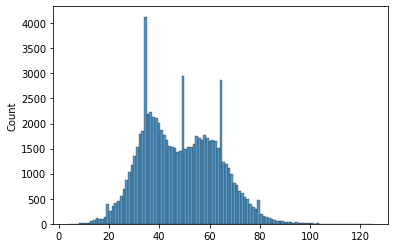

In [9]:
print(f"There are {len(inverted_index_sortpost.documents)} documents")
doc_lenghts=[len(inverted_index_sortpost.raw_freq[ID]) for ID in inverted_index_sortpost.documents]
sb.histplot(doc_lenghts)

In [11]:
round(pd.DataFrame({"doc_lengths": doc_lenghts}).describe(),0)

,doc_lengths
count,79176.0
mean,49.0
std,15.0
min,4.0
25%,37.0
50%,48.0
75%,60.0
max,125.0


### Word raw frequencies

In [12]:
# average number of time each token appears in a document
avg_raw_freqs = [np.mean([inverted_index_sortpost.raw_freq[ID][term] for ID in inverted_index_sortpost.index[term]]) for term in inverted_index_sortpost.index]
round(pd.DataFrame({"avg_raw_freqs":avg_raw_freqs}).describe(),0)

,avg_raw_freqs
count,132161.0
mean,1.0
std,0.0
min,1.0
25%,1.0
50%,1.0
75%,1.0
max,24.0


Most of the terms appear just once in a document.

### Document frequencies

In [13]:
doc_freqs=[len(inverted_index_sortpost.index[token]) for token in inverted_index_sortpost.index]
round(pd.DataFrame({"doc_freqs": doc_freqs}).describe(),0)

,doc_freqs
count,132161.0
mean,29.0
std,571.0
min,1.0
25%,1.0
50%,2.0
75%,5.0
max,73633.0


A term appears on average in 30 $\pm$ 500 documents, 75% of the terms appear in less than 5 documents (a lot of rare terms, weird ??). Lets try to visualize why.

In [14]:
for pos , term in enumerate(inverted_index_sortpost.index) : 
    if pos<=500 and len(inverted_index_sortpost.index[term])<=5: print(term) 

stink
relocate
scatter
deters
npr
contributory
coaltake
fuelsoil
circumscribes
apothems
4cm
polygonsproperties
incircle
congruent
equilateral
weisstein
sagitta
inradius
mathworld
hypotenuse


It looks plausible when we look at the above sequence of words (they look rare indeed)


### Relevance judgments

Judgments are used to evaluate models, each query is associated to some relevant documents, and those documents have a relevance score 


In [15]:
[f'{query}: {judgments[query]}' for pos, query in enumerate(judgments) if pos<=2]

['does human hair stop squirrels: {1: 1, 2: 1, 3: 2, 4: 1, 5: 1, 6: 1, 7: 1}',
 'what are the benefits of fossil fuels: {8: 1, 9: 2, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1, 15: 1, 16: 1}',
 'what is a apothem: {17: 1, 18: 1, 19: 1, 20: 1, 21: 1, 22: 2, 23: 1, 24: 1, 25: 1}']

In [18]:
round(pd.DataFrame({"nb_judgments":[len(judgments[query]) for query in judgments]}).describe(),0)

,nb_judgments
count,9650.0
mean,8.0
std,1.0
min,2.0
25%,7.0
50%,9.0
75%,9.0
max,11.0


On average 8 judgment(s) per query

In [17]:
print(f"The minimum and maximum relevance scores are {min([min(judgments[query].values()) for query in judgments])} and {max([max(judgments[query].values()) for query in judgments])} respectively")

The minimum and maximum relevance scores are 1 and 2 respectively


# Preparing for search

### TF-IDF and language model


By default, the **term frequency** TF(t,d) of a term $t$ in document $d$ is given by
$$
TF(t,d)= 1+\log_{10}(n_{t,d})
$$
where $n_{t,d}$ is the raw frequency (the number of occurences) of term $t$ in document $d$, and the **inverse document frequency** of $t$ is given by:
$$
IDF(t) = \log_{10}\bigg(\frac{|C|}{\big|\{d \in C, t\in d\}\big|}\bigg)
$$
where $C$ is the set of documents in the collection, and $|E|$ designates the cardinal of set $E$. Other variations of formula are also implemented. 

TF-IDFs are used to represent documents/queries in a same vector space (it is the Vector Space Model (Vsm)), coordinates being the TF-IDFs. This representation is sparse because documents/queries do not generally include most of the words in the collection). In Vsm, cosine similarity between query vector and document vectors is used to rank documents.


The language model used is the **unigram model** where each term appearing in the documents are modelled as random instances with probability distribution given by:
$$
\mathbb{P}(t|d) = \frac{n_{t,d}}{n_d}
$$
where $n_{t,d}$ is the total number of occurences (raw frequency) of $t$ in document $d$, and $n_d$ is the total of occurrences of all terms appearing in the collection (i.e the sum of the $n_{t',d}$ s). The language model is used to compute the query likelihood model (QueryLklhd) in which the aim is to estimate the probability $\mathbb{P}(q|d)$ of query $q$ given document $d$ and rank the documents in a decreasing order of the estimates. If $q="t_1 t_2 ... t_q"$ then

In the original version of query likelihood model, it is assumed 
$$\mathbb{P}(q|d) = \prod_{j=1}^q\mathbb{P}(t_j|d)$$

This formulation allows $\mathbb{P}(q|d)=0$ if there exists a term appearing in the query and not in the document. To avoid this, some extensions of the query likelihood model suggest a smoothing scheme (Laplace smoothing , Jelinek smoothing for example). These smoothings are not implemented yet, :). Instead the current implementation assumes $$\mathbb{P}(q|d) = \prod_{j=1 , t_j\in d}^q\mathbb{P}(t_j|d)$$

In [19]:
tfreqs, idfs, unigram_model=tf(inverted_index_sortpost), idf(inverted_index_sortpost), unigram(inverted_index_sortpost)


100%|██████████| 79176/79176 [00:05<00:00, 15449.05it/s]


### Uploading word2vec model

google news word2vec model is used, It takes roughly up to 10 minutes to download, Run it ONCE per session.

In [20]:
## Takes up to 10 minutes to run, but TO RUN ONCE !!!
path = api.load("word2vec-google-news-300", return_path=True)
# path="/root/gensim-data/word2vec-google-news-300/word2vec-google-news-300.gz"

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [21]:
# Takes up to 1 minute to load the google news word2vec model
w2v = gensim.models.KeyedVectors.load_word2vec_format(path, binary=True)

In [22]:
print(f"Word2Vec model vocabulary size = {len(w2v.key_to_index)} words")

Word2Vec model vocabulary size = 3000000 words


### Document embedding


Once we have the embeddings of the terms in the collection, one can compute the document embeddings by taking a weighted average of the embeddings of the terms it contains, that is the a document's embedding is given by:

$$
d_{embed} =  \sum_{t \in d} \frac{w_{t,d}}{\sum_{t'\in d} w_{t',d}}  t_{embed}
$$
where $w_{t,d}$ is a weight for term $t\in d$, $w_{t,d}=TF(t,d)\times IDF(t)$ is used in the current implementation

In [24]:
doc2vec=doc_embed(inverted_index_sortpost, tfreqs, idfs, w2v)

100%|██████████| 79176/79176 [00:44<00:00, 1781.19it/s]


 ### Document clustering

Once documents have a numerical vector-like representation, one can cluster them. Why clustering ? The main reason is to speed-up retrieval (see W2Vec vector space model illustration). In fact when the representation of vectors is dense, computing cosine similarities on a large collection may take time. To speed up retrieval, one can precluster the documents first before a query is issued. When a query comes in, the query vector is compared to the centers (or representer in general) of the clusters (so a relatively small number of cosine similarities to compute), and afterwards the query is compared by cosine similarity to the documents in the clusters whose centers/representers are the most similar to the query.  

Penalised inertia is used to compute the optimal Kmeans model with repect to the number of clusters. The objective is to minimise:

$$
\text{Penalised Inertia}(K) = \text{Inertia}(K) - \text{penalty}\times K
$$
w.r.t $K$

Computing K-means model for different values of K


100%|██████████| 2/2 [04:59<00:00, 149.72s/it]


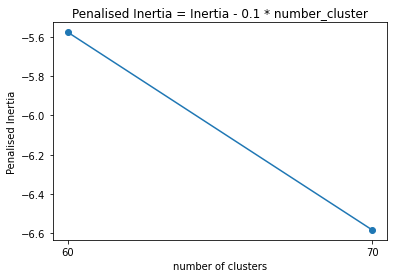

In [25]:
doc_kmeans=cluster_docs(inverted_index_sortpost, doc_embeds=doc2vec,num_min_centr=60,num_max_centr=80,step=10,plot=True)


### Singular Value Decomposition of a word-document occurrence matrix

This is used for latent semantic indexing, a model used in order to capture some semantic relation between the query and the documents in the collection. The idea behind this model is to start from a matrix whose coefficients are the raw frequencies of the terms in documents: 
$$
WD=(n_{t,d}) \in \mathbb{R}^{|T|\times |C|}
$$
where $T$ is the set of all the terms in the collection $C$.

An SVD decomposition of $WD$ is given by:
$$
WD = U S V
$$

where $U\in \mathbb{O}(|T|)$ and $V \in \mathbb{O}(|C|)$ are orthogonal matrices and $S\in \mathbb{R}^{|T|\times |C|}$ is a generalized diagonal matrix (all $S_{i,j}=0$ for $i\neq j$). $U$ represents the matrix of latent vectors expressed in the term space and $SV$ is the matrix of the document vectors expressed in the latent space
$$
\text{terms} \left\{
    \begin{array}{ll}
         &  \\
        & 
    \end{array}
\right. \overbrace{\begin{pmatrix}
 & & & \\
 & & & \\
 \end{pmatrix}}^{\text{latent vectors}}=U
$$

$$
\text{latent vectors} \left\{
    \begin{array}{ll}
         &  \\
        & 
    \end{array}
\right. \overbrace{\begin{pmatrix}
 & & & \\
 & & & \\
 \end{pmatrix}}^{\text{document vectors}}=SV
$$

To rank the documents, one projects the query vector on the latent space and compare the result to the documents representation in the latent space by cosine similarity (i.e computing $\cos(U'q, (SV)_i)$), $U'$ designates the transpose of $U$.

However from a practical point of view, $WD$ is very big in memory if we consider the whole collection (more than 10 billion integers to store in memory, easily more than 200 GB), that is why a random selection of documents is conducted first and $WD$ is built from those selected documents. 

In [30]:
sub_inv = SubInvertedIndex()
nb_docs=len(inverted_index_sortpost.documents)
nb_sampled_docs=1000
sampled_docs=np.random.choice(a=range(1,nb_docs+1),size=nb_sampled_docs, replace=False)
sub_inv.reindex(inverted_index_sortpost, sampled_docs)

100%|██████████| 1000/1000 [00:00<00:00, 699167.19it/s]


In [31]:
WD, wtoi, dtoi = wd(sub_inv)
WD.shape

1000it [00:00, 23286.94it/s]


(11426, 1000)

To speed up the retrieval a little bit, one chooses the K largest singular values of $WD$ instead and project the query vector on the space engendered by the corresponding latent vectors, not computing $\cos(U'q, (SV)_i)$ but computing $\cos(U_K'q, (S_KV_K)_i)$ to rank the documents, where $U_K \in \mathbb{R}^{|T|\times K}$, $S_K \in \mathbb{R}^{K\times K}$, $V_K \in \mathbb{R}^{K\times |C|}$.

The optimal $K$ is computed by maximizing with respect to $K$

$$
PSSV(K) = \sum_{k=1}^K \sigma_k - \text{penalty}\times K
$$

where $\sigma_k$ is the $k^{th}$ largest singular value of $WD$

Computing SVDs for different values of k


100%|██████████| 5/5 [02:18<00:00, 27.71s/it]


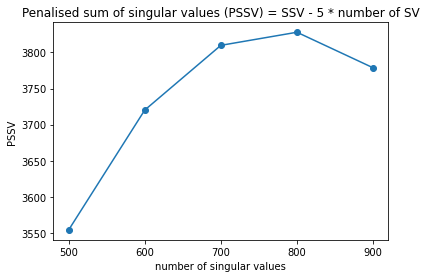

In [32]:
svd_mats=opt_svd(WD,min_k=500,max_k=1000,step_k=100, penalty=5,plot=True)

# Searching


### Simple boolean retrieval


In [33]:
bl=Boolean(index=inverted_index_sortpost, query_type="AND", correct_query=True)
searching(bl)

Welcome to the best search engine ever :)
Enter some keywords or type "exit" to stop the engine: where is France ?
Did you mean: where is trance ?


Your query:  where is France ?

Result(s): 
Nearly three times as much grenache is planted in Spain as in France. The spanish know this grape and wine as garnacha or garnacha tinta, where it is the dominant red wine variety in Catalonia and prominent in Rioja. 2 The grape is known in Italy as cannonau. Prior to the establishment of France's AOC, Burgundy's dirty little secret was that Grenache, grown in the Rhone Rhône, valley often contributed flavorful appeal to save the sometimes thin and Weak Pinot. Noir on its, own grenache can make, fleshy heady wines with lots of fruit appeal in their. youth 

Grenache (/ɡrəˈnɑːʃ/) or Garnacha (. [ɡarˈnatʃa]) is one of the most widely planted red wine grape varieties in the world. It ripens late, so it needs hot, dry conditions such as those found in Spain, where the grape most likely originated. It

### Vector Space Model

In [34]:
vsm=Vsm(index=inverted_index_sortpost, tfreqs=tfreqs, idfs=idfs, top=4, correct_query=False)
searching(vsm)

Welcome to the best search engine ever :)
Enter some keywords or type "exit" to stop the engine: where is France ?
Your query:  where is France ?

Result(s): 
The Pyrenees. Feedback: France and Spain are separated by the Pyrenees range of mountains. The Pyrenees, is a range of mountains in southwest Europe that forms a natural border between France and Spain.  

Hide summary. France to the west, Russia to the east; Germany had a strategic plan in case of war in... France to the west, Russia to the east; Germany had a strategic plan in case of war in the early 20th century.  

Definition of MISTRAL. : a strong cold dry northerly wind of southern France. ADVERTISEMENT. 

Toulouse is one of France's most beautiful cities. It's a city located in southwest France. The metropolitan area of Toulouse is the second largest in Southern France and one of the fastest growing in Southern Europe. It is also the fourth largest city of France. Toulouse is called the chief city of Midi-Pyrenees Region.

### Binary Independence models


In [35]:
bim=Bim(index=inverted_index_sortpost , top=3, correct_query=False)
searching(bim)

Your query:  save the world !!!

Result(s): 
The Answer: The first national observance of Daylight Saving Time in the United States was in 1918, to save energy during World War I. This lasted seven months before being repealed. A similar, year-round, national observance went into effect in World War II, starting February 9, 1942, and ending September 30, 1945. Beginning in 2007, the observance starts on the second Sunday in March and ends in the first Sunday in November, adding an additional month. For more on Daylight Saving Time around the world, click here. 

There are volcanoes all over the world. They are above sea level and below the oceans. What a volcano actually is a hole in the Earth’s crust that lava and other Earth debris come out of a lot of the. time or even hundreds of years apart. A lot of volcanoes are in a form of a mountain or a hill that have a crater from past eruptions. Many times, before an eruption, there is activity in the Earth’s surface that make the ground s

##### Improvement with some extensions

In [36]:
two_poisson=BimExt(index=inverted_index_sortpost,k=1.25, b=0, top=3)
searching(two_poisson)

Welcome to the best search engine ever :)
Enter some keywords or type "exit" to stop the engine: save the world !!!
Your query:  save the world !!!

Result(s): 
Definition of Green. Living a green lifestyle – or going green – can begin in small, easy to manage ways. Recycling is a huge, obvious part of helping to save the world through green living. Reducing one’s reliance on oil-based energy sources is another popular method employed in trying to save the world. 

Going Green Tips. Some people find that an easy way of going green and helping to save the planet is by creating a compost pile in their backyards. Planting a vegetable garden instead of water hugging grass is another method being used by many people who are trying to save the world. 

The Answer: The first national observance of Daylight Saving Time in the United States was in 1918, to save energy during World War I. This lasted seven months before being repealed. A similar, year-round, national observance went into effect 

In [37]:
bm11=BimExt(index=inverted_index_sortpost, top=3, k=1.5, b=1)
searching(bm11)

Welcome to the best search engine ever :)
Enter some keywords or type "exit" to stop the engine: save the world !!!
Your query:  save the world !!!

Result(s): 
Definition of Green. Living a green lifestyle – or going green – can begin in small, easy to manage ways. Recycling is a huge, obvious part of helping to save the world through green living. Reducing one’s reliance on oil-based energy sources is another popular method employed in trying to save the world. 

Going Green Tips. Some people find that an easy way of going green and helping to save the planet is by creating a compost pile in their backyards. Planting a vegetable garden instead of water hugging grass is another method being used by many people who are trying to save the world. 

In Acrobat Reader DC Save As Save As. To save a copy of a PDF Portfolio Save As Other PDF Portfolio. If you are viewing a PDF in a web browser, the Acrobat File menu is not available. Use the Save A Copy button in the Acrobat toolbar to save t

In [38]:
bm25=BimExt(index=inverted_index_sortpost, top=3, k=1.5, b=0.8)
searching(bm25)

Welcome to the best search engine ever :)
Enter some keywords or type "exit" to stop the engine: save the world !!!
Your query:  save the world !!!

Result(s): 
Definition of Green. Living a green lifestyle – or going green – can begin in small, easy to manage ways. Recycling is a huge, obvious part of helping to save the world through green living. Reducing one’s reliance on oil-based energy sources is another popular method employed in trying to save the world. 

Going Green Tips. Some people find that an easy way of going green and helping to save the planet is by creating a compost pile in their backyards. Planting a vegetable garden instead of water hugging grass is another method being used by many people who are trying to save the world. 

In Acrobat Reader DC Save As Save As. To save a copy of a PDF Portfolio Save As Other PDF Portfolio. If you are viewing a PDF in a web browser, the Acrobat File menu is not available. Use the Save A Copy button in the Acrobat toolbar to save t

### Language model

In [39]:
ql=QueryLklhd(index=inverted_index_sortpost, lang_model=unigram_model, top=3)
searching(ql)

Welcome to the best search engine ever :)
Enter some keywords or type "exit" to stop the engine: save the world !!!
Your query:  save the world !!!

Result(s): 
The shorter the pushrod side of the rocker arm and the longer the valve side of the rocker arm, the higher the lift ratio of the rocker. If the length of the valve side of the rocker is 1.5 times that of the pushrod side, the lift ratio will be 1.5:1.  

Remove the Transmission from the Vehicle. Place a transmission jack underneath the transmission. Raise the jack until it is supporting the weight of the transmission. Remove the bolts that connect the engine to the transmission. Remove the bolts that secure the transmission to the engine. Remove the bolts that secure the transmission to the transmission crossmember. Remove the bolts that connect the transmission crossmember to the vehicle's frame. Remove the transmission crossmember from the vehicle. Slide the transmission rearward until the front of the transmission housing di

### Word2Vec Vector Space model

In [40]:
# This takes up to 10 seconds to run a query
w2vvsm_np=W2Vsm(index=inverted_index_sortpost, top=3, idfs=idfs, word_embeds=w2v, doc_embeds=doc2vec, precluster=False)
searching(w2vvsm_np)

Welcome to the best search engine ever :)
Enter some keywords or type "exit" to stop the engine: What is AIDS ?


100%|██████████| 79176/79176 [00:15<00:00, 5128.06it/s]


Your query:  What is AIDS ?

Result(s): 
Physical therapist assistants (PTAs) work as part of a dynamic healthcare team. Assistants help physical therapists maintain therapy facilities and monitor patient progress, while also helping patients by assisting them on difficult movements and instructing them on how to use walking aids.  

Biofeedback sessions are typically done in a therapist's office, but there are computer programs that connect the biofeedback sensor to your own computer. A biofeedback therapist helps you practice relaxation exercises, which you fine-tune to control different body functions. Researchers aren't exactly sure how or why biofeedback works. They do know that biofeedback promotes relaxation, which can help relieve a number of conditions that are related to stress. During a biofeedback session, electrodes are attached to your skin. Finger sensors can also be used. These electrodes/sensors send signals to a monitor, which displays a sound, flash of light, or imag

In [41]:
w2vvsm_p=W2Vsm(index=inverted_index_sortpost, idfs=idfs, top=3, word_embeds=w2v, doc_embeds=doc2vec, precluster=True,
               cluster_centers=doc_kmeans.cluster_centers_, doc_cluster_labels=doc_kmeans.labels_, top_center=10)
searching(w2vvsm_p)

Welcome to the best search engine ever :)
Enter some keywords or type "exit" to stop the engine: What is AIDS ?
Your query:  What is AIDS ?

Result(s): 
Physical therapist assistants (PTAs) work as part of a dynamic healthcare team. Assistants help physical therapists maintain therapy facilities and monitor patient progress, while also helping patients by assisting them on difficult movements and instructing them on how to use walking aids.  

Biofeedback sessions are typically done in a therapist's office, but there are computer programs that connect the biofeedback sensor to your own computer. A biofeedback therapist helps you practice relaxation exercises, which you fine-tune to control different body functions. Researchers aren't exactly sure how or why biofeedback works. They do know that biofeedback promotes relaxation, which can help relieve a number of conditions that are related to stress. During a biofeedback session, electrodes are attached to your skin. Finger sensors can a

### Latent semantic indexing


In [42]:
lsi=Lsi(index=sub_inv, idfs=idfs, top=3, svd_word_doc_mat=svd_mats, dtoi=dtoi, wtoi=wtoi)
searching(lsi)

Welcome to the best search engine ever :)
Enter some keywords or type "exit" to stop the engine: What is AIDS ?
Your query:  What is AIDS ?

Result(s): 
Blood pressure is highest at the aorta and decreases as it travels and divides into arteries, arterioles, and capillaries making the flow slow and smooth for nutrient and gas exchange. Because the aorta is a flexible artery, it beats accordingly with the heart. It made up of an assorted mixture of nerves, endothelial cells, complex extracellular matrix, fibroblast-like cells, intimal cells and smooth muscles. If you like this article, you might also like.... 1  What is Aortic Aneurysm? 2  What is aortic dissection? 3  What is aortic stenosis? 4  What is Lymphatic System? 5  What is aortic regurgitation? 6  What is CDH? 7  What is Angina? 8  What is Low Blood Pressure? 9  What is Oxygen Saturation? 10  What is CVD? 

Like a river current is the flow water of water molecules, electrical current is the flow of charged particles. In this l

# Evaluation

In [43]:
[f'{query}: {judgments[query]}' for pos, query in enumerate(judgments) if pos<=2]

['does human hair stop squirrels: {1: 1, 2: 1, 3: 2, 4: 1, 5: 1, 6: 1, 7: 1}',
 'what are the benefits of fossil fuels: {8: 1, 9: 2, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1, 15: 1, 16: 1}',
 'what is a apothem: {17: 1, 18: 1, 19: 1, 20: 1, 21: 1, 22: 2, 23: 1, 24: 1, 25: 1}']

In [48]:
benchmark={
      "vsm": {"model":[Vsm(index=inverted_index_sortpost, tfreqs=tfreqs, idfs=idfs)]},
      "bim": {"model":[Bim(index=inverted_index_sortpost)]},
      "query_likelihood": {"model":[QueryLklhd(index=inverted_index_sortpost, lang_model=unigram_model)]}, 
      "w2vvsm_precluster":{"model":[W2Vsm(index=inverted_index_sortpost, idfs=idfs, word_embeds=w2v, doc_embeds=doc2vec, precluster=True,\
                              cluster_centers=doc_kmeans.cluster_centers_, doc_cluster_labels=doc_kmeans.labels_, top_center=10)]},
      "lsi": {"model":[Lsi(index=sub_inv, idfs=idfs, svd_word_doc_mat=svd_mats, dtoi=dtoi, wtoi=wtoi)]}     
           }

# ks=np.linspace(1,2,10)
# bs=np.linspace(0.05,0.95,10)
ks=[1.5]
bs=[0.75]
at_Ks=[10]

for ext in ["two_poisson", "bm11"]:
      benchmark[ext]={"model":[BimExt(index=inverted_index_sortpost, b=(ext=="bm11")*1, k=k) for k in ks]}
benchmark["bm25"]={"model":[BimExt(index=inverted_index_sortpost, b=b, k=k) for b in bs for k in ks]}

for m in benchmark:
      benchmark[m]["MRR@"]={K: [] for K in at_Ks}
      benchmark[m]["MAP"] = []

subjudgments={query: rel for pos, (query, rel) in enumerate(judgments.items()) if pos<100}

results=run_benchmark(benchmark, subjudgments)


Running 1 vsm model(s)
	1 model over 1


100%|██████████| 100/100 [08:34<00:00,  5.15s/it]


Running 1 bim model(s)
	1 model over 1


100%|██████████| 100/100 [00:18<00:00,  5.49it/s]


Running 1 query_likelihood model(s)
	1 model over 1


100%|██████████| 100/100 [00:15<00:00,  6.53it/s]


Running 1 w2vvsm_precluster model(s)
	1 model over 1


100%|██████████| 100/100 [03:37<00:00,  2.17s/it]


Running 1 lsi model(s)
	1 model over 1


100%|██████████| 100/100 [01:44<00:00,  1.04s/it]


Running 1 two_poisson model(s)
	1 model over 1


100%|██████████| 100/100 [00:36<00:00,  2.73it/s]


Running 1 bm11 model(s)
	1 model over 1


100%|██████████| 100/100 [00:37<00:00,  2.68it/s]


Running 1 bm25 model(s)
	1 model over 1


100%|██████████| 100/100 [00:37<00:00,  2.68it/s]


In [47]:
best={'MRR@': {K: {model_name:None for model_name in benchmark} for K in at_Ks},
      'MAP':  {model_name: None for model_name in benchmark}
     }

for model_name in benchmark:
    # sort models with respect to each metric
    models=benchmark[model_name]["model"]
    # print(len(models))
    for K in at_Ks:
        MRRAtKs=benchmark[model_name]["MRR@"][K]
        # print(MRRAtKs)
        best_model, bestMRRAtK=models[0], MRRAtKs[0]
        for pos,model in enumerate(models[1:]):
            if MRRAtKs[pos]>bestMRRAtK:
                best_model, bestMRRAtK=models[pos], MRRAtKs[pos]
        best["MRR@"][K][model_name]=(best_model.name, bestMRRAtK)
    MAPs=benchmark[model_name]["MAP"]
    best_model, bestMAP=models[0], MAPs[0]
    for pos, model in enumerate(models[1:]):
        if MAPs[pos]>bestMAP:
            best_model, bestMAP=models[pos], MAPs[pos]
    best["MAP"][model_name]=best_model.name, bestMAP

for K in best["MRR@"]:
    best_model=sorted(best["MRR@"][K].items(),key=lambda item: item[1][1], reverse=True)[0][0]
    print(f"Best model with respect to MRR@{K} is {best_model}\n")

best_model=sorted(best["MAP"].items(),key=lambda item: item[1][1], reverse=True)[0][0]
print(f"Best model with respect to MAP is {best_model}\n")

Best model with respect to MRR@10 is two_poisson

Best model with respect to MAP is two_poisson

